Tune learning rate (-r) and regularization strength (-b).
Do randomized grid search.

In [1]:
import numpy as np
import os
import re
import subprocess

## Results

- w/ device_* cols
    + `train_site_small`: 26m.
        (lr, reg, score): (0.27036067125394514, 0.0002883992671365484, 0.446741),
 (0.13684364782198308, 7.794451026230775e-06, 0.446769),
 (0.0706468934861553, 8.967904921004762e-06, 0.446839)
    + `train_app_small`: 14m.
        (lr, reg, score): (0.164879982368552, 5.998052351848339e-05, 0.340261),
 (0.11218764413671876, 2.5561112811476586e-05, 0.340286),
 (0.40504999930569235, 0.00012167825036020641, 0.34044)

- w/o device_* cols
     + `train_site_small`: learning_rate in (1e-3, 1e1), reg_param in (1e-2, 1e1).
    Try (lr, reg, score) = (1.5055668655636434, 0.14551999446480063), (0.10494282632180114, 1.299328348582395e-06, 0.447807)
     + `train_app_small`: (lr, reg, score) = (0.00166189386987065, 0.48305136367563084), (0.3836766261280591, 9.207841986673778e-05, 0.341098)

In [2]:
def parse_best_loss(run_result):
    lines = run_result.stdout.decode().split('\n')
    best_loss_line = [l for l in lines if 'best loss' in l]
    if best_loss_line:
        best_loss_line = best_loss_line[0]
        best_loss = re.search(r'best loss: (\d+.\d+)', best_loss_line).group(1)
        return float(best_loss)
    else:
        # No line matches 'best loss' if early stopping wasn't necessary.
        # Given the fact that FFM is very likely to overfit, this result
        # is most likely not of our interest.
        return np.nan

def eval_param(train_set, validation_set, learning_rate=0.2, reg_param=1e-5):
    xlearn_train = '~/code/xlearn/build/xlearn_train'
    command = [xlearn_train, train_set,
          '-s 2',
         '-v', validation_set,
          '-r', str(learning_rate),
               '-b', str(reg_param)]
    command = ' '.join(command)
    result = subprocess.run(command, stdout=subprocess.PIPE, shell=True)
    return parse_best_loss(result)

def log_uniform(low=0, high=1, size=None):
    return np.power(10, np.random.uniform(low, high, size))

def eval_param_ls(train_set, validation_set, learning_rates, reg_params):
    scores = [eval_param(train_set, validation_set, lr, reg)
              for lr, reg in zip(learning_rates, reg_params)]
    
    minidx = np.nanargmin(np.array(scores))
    min_score = scores[minidx]
    best_lr = learning_rates[minidx]
    best_reg = reg_params[minidx]
    return min_score, best_lr, best_reg, scores

In [15]:
def best_scores(scores, k):
    top_k = sorted([s for s in scores if s is not np.nan])[:k]
    params = []
    for s in top_k:
        best_idx = scores.index(s)
        params.append((learning_rates[best_idx], reg_params[best_idx], s))
    return params

In [17]:
size=100
learning_rates = log_uniform(-2,1,size) # default = 0.2
reg_params = log_uniform(-6,3,size) # default = 1e-5

In [18]:
data_type='app'
project_path = '~/code/avazu-ctr/'
xlearn_train = '~/code/xlearn/build/xlearn_train'
train_set = os.path.join(project_path, f'ffm-data/train_{data_type}_small.ffm')
validation_set = os.path.join(project_path, f'ffm-data/validate_{data_type}_small.ffm')

In [19]:
%%time
best_score, best_lr, best_reg, scores = eval_param_ls(train_set, validation_set, learning_rates, reg_params)

CPU times: user 89.7 ms, sys: 234 ms, total: 323 ms
Wall time: 14min 17s


In [20]:
best_scores(scores, 20)

[(0.164879982368552, 5.998052351848339e-05, 0.340261),
 (0.11218764413671876, 2.5561112811476586e-05, 0.340286),
 (0.40504999930569235, 0.00012167825036020641, 0.34044),
 (0.3093052570250611, 9.47949496666335e-06, 0.340675),
 (0.5348991076680404, 0.00018567769335418557, 0.340693),
 (0.16038342845423564, 3.848731234050697e-06, 0.34102),
 (0.16675014706792918, 1.4421359209648728e-06, 0.341142),
 (0.2942899713792451, 2.184833901607596e-06, 0.341148),
 (0.541599419591939, 0.0007865319553050016, 0.342135),
 (1.3899820581352431, 0.0003311589989875838, 0.342292),
 (0.5845438277233063, 1.2869889775575957e-05, 0.342556),
 (0.9391955004648032, 1.795371992021529e-06, 0.343127),
 (0.737621795834793, 7.059491116712587e-06, 0.343185),
 (0.9326471936209265, 1.0900014603369086e-06, 0.343921),
 (2.2587216593061497, 0.0008192279058030402, 0.345189),
 (2.0066762755168206, 0.00011587824961114747, 0.34639),
 (1.9537240238986344, 1.1993261634325936e-05, 0.346873),
 (2.2187965245627517, 7.616427062668768e-06

In [8]:
# find a score for a parameter pair that didn't overfit.
best_score = min([s for s in scores if s > 0.30])
best_idx = scores.index(best_score)
learning_rates[best_idx], reg_params[best_idx], best_score

(0.27036067125394514, 0.0002883992671365484, 0.446741)

(0.00166189386987065, 0.48305136367563084)

In [68]:
max_score, best_lr, best_reg

(0.073864, 5.8180412773539905, 0.15273521840224266)

In [58]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

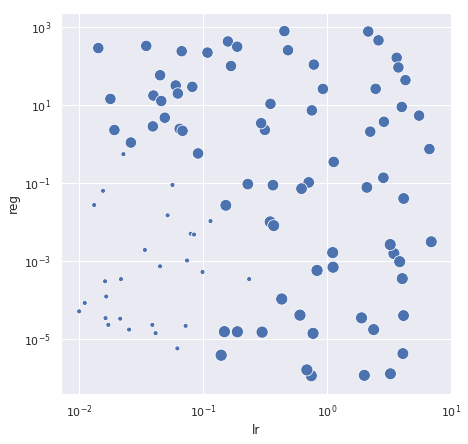

In [156]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log", xlabel='lr', ylabel='reg')
points = [0.5 if s is np.nan or s > 1 else 1/s for s in scores]
sns.scatterplot(learning_rates, reg_params, s=[50*p for p in points])

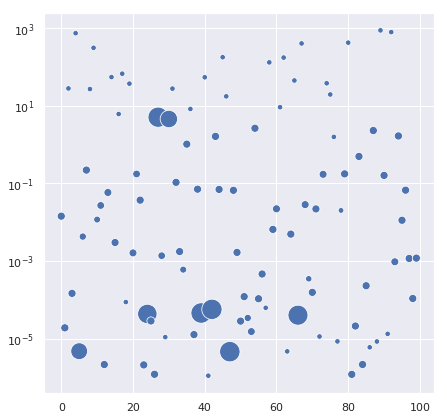

In [88]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
points = [1 if s is np.nan or s > 1 else 1/s for s in scores]
sns.scatterplot(range(size), learning_rates, s = [30*p for p in points])